In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
import torch
from torch.nn import MSELoss
from torchvision import transforms
from PIL import Image
from monai.networks.blocks import Warp
from monai.networks.nets import GlobalNet
from monai.losses import BendingEnergyLoss
import numpy as np
from scipy import stats

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
!unzip -qq /content/drive/MyDrive/MRI_data/2D_10000.zip;
#!unzip -qq /content/drive/MyDrive/MRI_data/2Dgrappa_1000.zip;

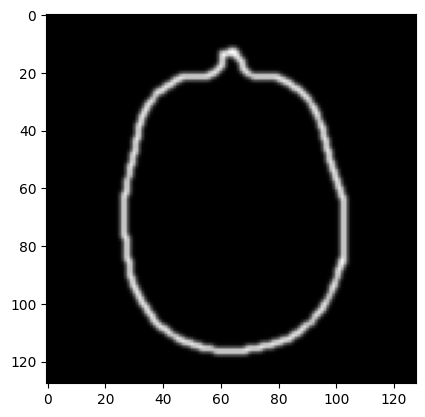

In [ ]:
device = torch.device("cuda:0")
import matplotlib.pyplot as plt
fixed = Image.open('/content/fixed_image.png')
fixed = fixed.crop((35, 75, 163, 203)) #cropping to a more suitable size

#plt.figure("check", (12, 6))
plt.imshow(fixed, cmap="gray")

plt.show()

In [ ]:
#n =  1001 #number of augmented images + 1
fixed = Image.open('/content/fixed_image.png')
fixed = fixed.crop((35, 75, 163, 203)) #cropping to a more suitable size
convert_tensor = transforms.ToTensor()
fixed = convert_tensor(fixed)
fixed1 = fixed.unsqueeze(0)
fixed1 = fixed1.to(device)
print(fixed1.size())

"""list1 = []
for i in range (1,n):
  moving = Image.open(f'/content/train/00{i}_rt.png')
  moving = moving.crop((35, 75, 163, 203))
  moving = convert_tensor(moving)
  moving1 = moving.unsqueeze(0)
  moving1 = moving1.to(device)
  list1.append(moving1)

#inputt = torch.cat((fixed, moving), dim=1)"""

torch.Size([1, 1, 128, 128])


"list1 = []\nfor i in range (1,n):\n  moving = Image.open(f'/content/train/00{i}_rt.png')\n  moving = moving.crop((35, 75, 163, 203))\n  moving = convert_tensor(moving)\n  moving1 = moving.unsqueeze(0)\n  moving1 = moving1.to(device)\n  list1.append(moving1)\n\n#inputt = torch.cat((fixed, moving), dim=1)"

In [ ]:
#translations parameters - x and y are swapped for these coordinates vs mri ones, rotations are clockwise in degrees
rotations = []
translations_x = []
translations_y = []
for i in range(1, n):
    with open(f"/content/train/00{i}_augments.txt") as f:
        lines = f.readlines()

        line0 = lines[0]
        r = float(line0.split("=")[1])
        #convert to radians
        r = (r*np.pi)/180
        rotations.append(r)

        line1 = lines[1]
        ty = float(line1.split("=")[1])
        #translations in y are relatively negative
        translations_y.append(-ty)

        line2 = lines[2]
        tx = float(line2.split("=")[1])
        translations_x.append(tx)

In [ ]:
ddfs = []
for (tx, ty, r) in zip(translations_x, translations_y, rotations):
  image_width = 128
  image_height = 128

  # Create mesh grid
  x, y = np.meshgrid(range(image_height), range(image_width), indexing='ij')

  # Initialize tensor
  displacement_field = np.zeros((image_height, image_width, 2))

  # Apply transformation parameters - affine transformation matrix: [[cos(r), sin(r), Tx], [-sin(r), cos(r), Ty]]
  homogeneous_coordinates = np.stack([x.flatten(), y.flatten(), np.ones_like(x.flatten())])
  transformation_matrix = np.array([[np.cos(r), np.sin(r), tx], [-np.sin(r), np.cos(r), ty]])
  transformed_homogeneous_coordinates = transformation_matrix @ homogeneous_coordinates

  # Compute displacement field
  displacement_field[..., 0] = transformed_homogeneous_coordinates[0].reshape((image_height, image_width)) - x
  displacement_field[..., 1] = transformed_homogeneous_coordinates[1].reshape((image_height, image_width)) - y

  displacementfield0 = torch.tensor(displacement_field)
  displacementfield = displacementfield0.unsqueeze(0)
  displacementfield = displacementfield.permute(0, 3, 1, 2)
  displacementfield = displacementfield.to(device)
  ddfs.append(displacementfield)

#print(ddfs[1])
  

In [ ]:
activation = {}


def get_activation(name):
    def hook(net, input, output):
        activation[name] = output.detach()

    return hook

def custom_loss(result, displacementfield):
    return torch.mean((result - displacementfield)**2)

input_param = {
    "image_size": (128, 128),
    "spatial_dims": 2,
    "in_channels": 2,
    "num_channel_initial": 16,
    "depth": 3,
}
net = GlobalNet(**input_param).to(device)
net.output_block.fc.register_forward_hook(get_activation("fc"))
regularization = BendingEnergyLoss()
optimizer = torch.optim.Adam(net.parameters(), 1e-5)

In [ ]:
def custom_loss1(result, displacementfield):
  transformed_points = fixed1 + result
  ground_truth_points = fixed1 + displacementfield

  # Compute Chamfer distance between transformed points and ground truth points
  return (torch.mean(torch.min(torch.sum((transformed_points[:, None, :] - ground_truth_points[None, :, :])**2, dim=2), dim=1).values) + torch.mean(torch.min(torch.sum((ground_truth_points[:, None, :] - transformed_points[None, :, :])**2, dim=2), dim=1).values))/2


In [ ]:
transmats = []
for (tx, ty, r) in zip(translations_x, translations_y, rotations):

  transmat0 = np.array([[np.cos(r), np.sin(r), tx],
                          [-np.sin(r), np.cos(r), ty]])
  transmat = torch.tensor(transmat0)
  transmat.to(device)
  transmats.append(transmat)

In [ ]:
def customloss2(result, transmat):
    # update translation values
    trans_x = (result[:, 0, 0, 0])
    trans_y = (result[:, 1, 0, 0])
    # update rotation values
    theta = torch.atan2(result[:, :, :, 1], result[:, :, :, 0])
    theta_mean = 2*theta.mean(dim=(1, 2))
    cos_theta = torch.cos(theta_mean)
    sin_theta = torch.sin(theta_mean)
    transform_matrix = [[cos_theta, -sin_theta, trans_x],
        [sin_theta, cos_theta, trans_y]]
    transformation_matrix1 = torch.tensor(transform_matrix, requires_grad=True)
    transformation_matrix1.to(device)
    
    return torch.mean((transformation_matrix1 - transmat)**2)

Loading in a pre-trained model if need be

In [ ]:
net.load_state_dict(torch.load('/content/drive/MyDrive/MRI_data/2transrot_40.pth'))
net.eval()

GlobalNet(
  (encode_convs): ModuleList(
    (0): Sequential(
      (0): Convolution(
        (conv): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (adn): ADN(
          (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (A): ReLU()
        )
      )
      (1): RegistrationResidualConvBlock(
        (layers): ModuleList(
          (0-1): 2 x Convolution(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
        (norms): ModuleList(
          (0-1): 2 x BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (acts): ModuleList(
          (0-1): 2 x ReLU()
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (adn): ADN(
          (N): BatchNorm2d(32, eps=1e-05, momentum=0.1, affin

In [ ]:
#number of trainable parameters,
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Number of trainable parameters: 686790


In [ ]:
max_epochs = 75
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    net.train()
    epoch_loss, step = 0, 0
    for (moving1, displacementfield) in zip(list1, ddfs):
        step += 1
        optimizer.zero_grad()
        result = net(torch.cat((fixed1, moving1), dim=1))
        loss = custom_loss(result, displacementfield) + 100 * regularization(result) #was 10 previously
        #loss = custom_loss1(result, displacementfield)
        #loss = customloss2(result, transmat)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

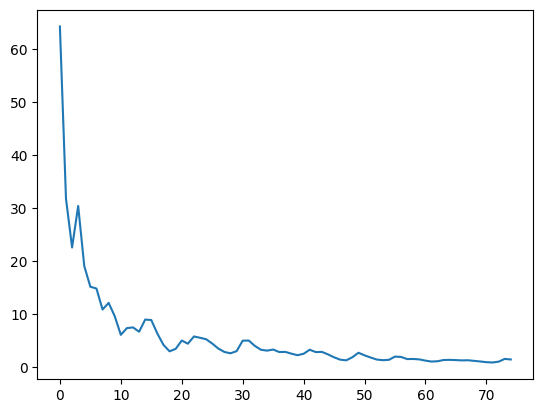

In [ ]:
%matplotlib inline
plt.plot(epoch_loss_values)

Now with validation data

In [ ]:
m = 101 #number of test data

list2 = []
for i in range (1,m):
  moving = Image.open(f'/content/test/00{i}_rt.png')
  moving = moving.crop((35, 75, 163, 203))
  moving = convert_tensor(moving)
  moving2 = moving.unsqueeze(0)
  moving2 = moving2.to(device)
  list2.append(moving2)

In [ ]:
import timeit
start = timeit.default_timer()
activations = []
for moving2 in list2:
    ddf = net(torch.cat((moving2, fixed1), dim=1))
    #pred_image = warp_layer(moving2, ddf)
    #print(activation)
    #pred_image = pred_image.detach().cpu().numpy()[:, 0]
    activations.append(activation['fc'])

#activations[10]['fc'][0,2].item()
stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  0.22881125899999688


In [ ]:

#each activation is [[cos(r), sin(r), Tx], [-sin(r), cos(r), Ty]]
predx = []

for activation in activations:
  a = activation[0,2].item()
  predx.append(a)

predy = []

for activation in activations:
  b = activation[0,5].item()
  predy.append(b)

#now for rotations it will be a bit trickier as there are four outputs to get the angle from - only averaging over the sin angles as the cos values can overshoot 1
predr = []

for activation in activations:
  c = activation[0, 0].item()
  d = activation[0, 1].item()
  e = activation[0, 3].item()
  f = activation[0, 4].item()

  g = (np.arcsin(d) + np.arcsin(-e))/2
  predr.append(g)


In [ ]:
#translations parameters for test data
#y:
test_x = []
test_y = []
test_r = []
for i in range(1, m):
    with open(f"/content/test/00{i}_augments.txt") as f:
        lines = f.readlines()
        line0 = lines[0]
        r1 = float(line0.split("=")[1])
        #convert to radians
        r1 = (r1*np.pi)/180
        test_r.append(r1)
        #Cartesian convention
        line1 = lines[2]
        t1 = float(line1.split("=")[1])
        test_x.append(t1)
        line2 = lines[1]
        t2 = float(line2.split("=")[1])
        test_y.append(-t2)

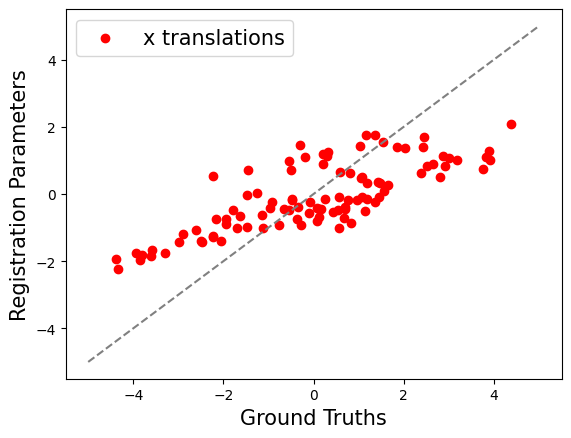

In [ ]:
%matplotlib inline
plt.scatter(test_x, predx, label="x translations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)

plt.legend(fontsize=15, loc='upper left')

plt.plot([-5, 5], [-5, 5], linestyle='--', color='gray')


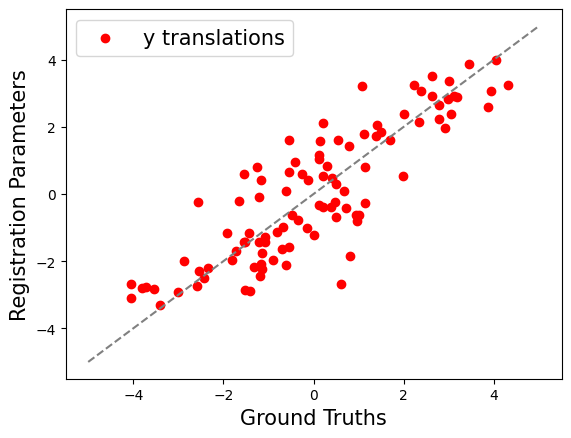

In [ ]:
%matplotlib inline
plt.scatter(test_y, predy, label="y translations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)

plt.legend(fontsize=15, loc='upper left')

plt.plot([-5, 5], [-5, 5], linestyle='--', color='gray')


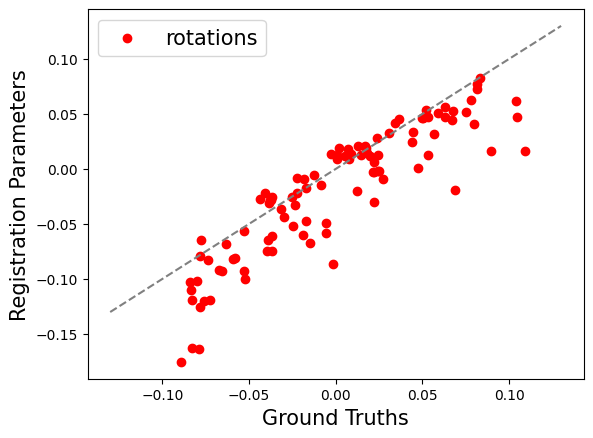

In [ ]:
%matplotlib inline
plt.scatter(test_r, predr, label="rotations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)

plt.legend(fontsize=15, loc='upper left')

plt.plot([-0.13, 0.13], [-0.13, 0.13], linestyle='--', color='gray')


In [ ]:
#torch.save(net.state_dict(), '/content/drive/MyDrive/MRI_data/2D_new.pth')

In [ ]:
differences = []
for (r, rr, x, xr, y, yr) in zip(test_r, predr, test_x, predx, test_y, predy):
    # normalise each absolute difference to the ground truth parameter for that variable
    differences.append([np.abs((r - rr) / r), np.abs((x - xr) / x), np.abs((y - yr) / y)])

# separating the data out into lists for each difference in parameter - way to do this earlier on in the code?
n_map = ['rotation abs difference norm', 'x translation abs difference norm', 'y translation abs difference norm']
for n in range(3):
    data_xr = []
    for i, difference in enumerate(differences):
        data_xr.append(difference[n])
    # for labelling
    n = n_map[n]
    # analysis - rounding to 2 dp
    mean = np.mean(data_xr)
    mean = np.round(mean, 2)
    median = np.median(data_xr)
    median = np.round(median, 2)
    mode = stats.mode(data_xr)
    mode = mode.mode[0]
    mode = round(mode, 2)
    stddev = np.std(data_xr)
    stddev = np.round(stddev, 2)
    variance = np.var(data_xr)
    variance = np.round(variance, 2)

    print(f"{n} Mean: {mean}\n")
    print(f"{n} Median : {median}\n")
    print(f"{n} Mode: {mode}\n")
    print(f"{n} SD: {stddev}\n")
    print(f"{n} Var: {variance}\n")

rotation abs difference norm Mean: 1.69

rotation abs difference norm Median : 0.45

rotation abs difference norm Mode: 0.01

rotation abs difference norm SD: 5.5

rotation abs difference norm Var: 30.24

x translation abs difference norm Mean: 1.39

x translation abs difference norm Median : 0.7

x translation abs difference norm Mode: 0.01

x translation abs difference norm SD: 1.82

x translation abs difference norm Var: 3.33

y translation abs difference norm Mean: 159.26

y translation abs difference norm Median : 0.49

y translation abs difference norm Mode: 0.01

y translation abs difference norm SD: 1571.49

y translation abs difference norm Var: 2469578.32



<ipython-input-16-646e85ab56b0>:19: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(data_xr)


Testing section